In [25]:
import pandas as pd

import numpy as np
from sklearn.neighbors import NearestNeighbors

# Load dataset
df = pd.read_csv('../data_csv/customer_neighbors.csv') 
df = df.dropna()

# Convert latitude and longitude to radians
coords = np.radians(df[['latitude', 'longitude']])

# Fit kNN model (k=5 is typical, adjust as needed)
k = 20
nbrs = NearestNeighbors(n_neighbors=k+1,  # +1 to include the point itself
                        algorithm='ball_tree',
                        metric='haversine').fit(coords)

# Compute distances
distances, indices = nbrs.kneighbors(coords)

# Skip the first column (distance to self = 0), convert from radians to kilometers
avg_distances = distances[:, 1:].mean(axis=1) * 6371  # Earth's radius in km

# Add to DataFrame
df['avg_neighbor_distance_km'] = avg_distances
df.head(20)
df = df[['customer_unique_id', 'avg_neighbor_distance_km']]
df.head(20)


,customer_unique_id,avg_neighbor_distance_km
0,861eff4711a542e4b93843c6dd7febb0,0.468284
1,290c77bc529b7ac935b93aa66c333dc3,0.090499
2,060e732b5b29e8181a18229c7b0b2b5e,0.124451
3,259dac757896d24d7702b9acbbff3f3c,0.811154
4,345ecd01c38d18a9036ed96c73b8d066,0.000000
5,4c93744516667ad3b8f1fb645a3116a4,1.229255
6,addec96d2e059c80c30fe6871d30d177,0.010349
7,57b2a98a409812fe9618067b6b8ebe4f,2.201507
8,1175e95fb47ddff9de6b2b06188f7e0d,0.250733
9,9afe194fb833f79e300e37e580171f22,0.000000


In [26]:
# current best model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

machine_learning = pd.read_csv('../data_csv/machine_learning_1.csv')
machine_learning = machine_learning.merge(
    df[['customer_unique_id', 'avg_neighbor_distance_km']],
    on='customer_unique_id',
    how='left'
)
# Create interaction feature: freight value divided by product weight
machine_learning['freight_per_weight'] = machine_learning.apply(
    lambda row: row['freight_value'] / row['total_order_weight'] if row['total_order_weight'] > 0 and pd.notnull(row['total_order_weight']) else np.nan,
    axis=1
)

# Include the new features in the feature set
features = ['unique_seller_count', 'delivery_time_buffer', 'product_count',  'estimate_length', 'freight_value', 'freight_per_weight', 'price', 'distance', 'category', 'same_state',  'avg_neighbor_distance_km']
X = pd.get_dummies(machine_learning[features].dropna(), columns=[ 'category'])
y = machine_learning.loc[X.index, 'late']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

y_pred_proba = clf.predict_proba(X_test)[:, 1]



# Note, adding the customer and seller states may add too many features and lowers model performance
# perhaps, we can change the customer state to regional columns.

Accuracy: 0.9380093007380861

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     21601
           1       0.96      0.22      0.36      1838

    accuracy                           0.94     23439
   macro avg       0.95      0.61      0.66     23439
weighted avg       0.94      0.94      0.92     23439



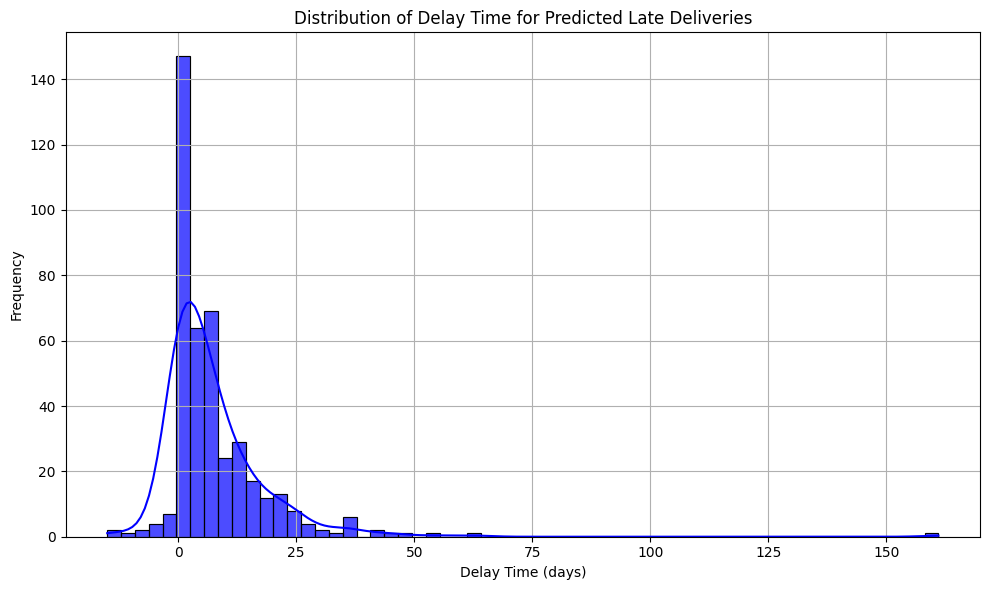

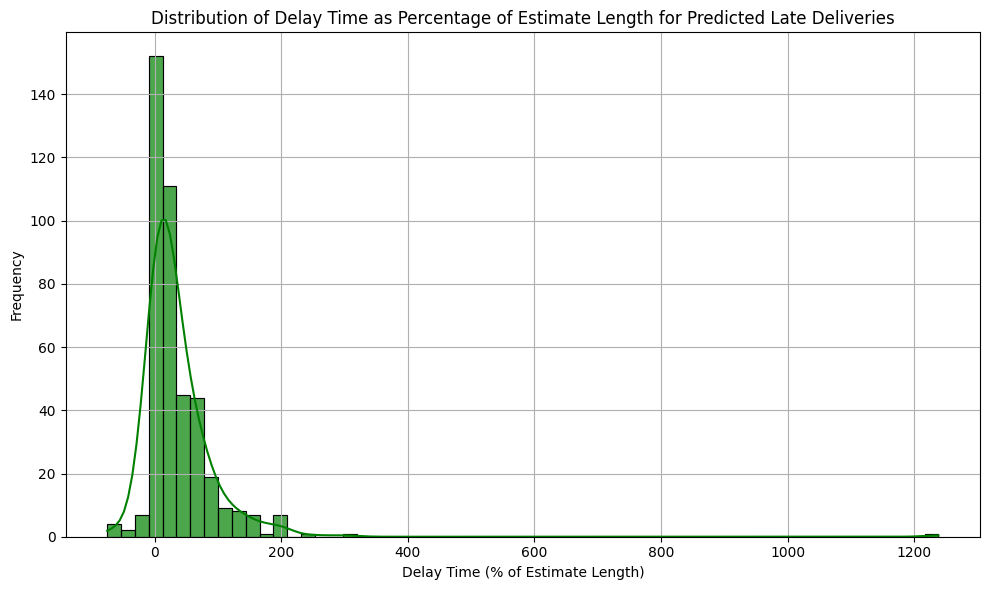

,customer_unique_id,delay_time,unique_seller_count,delivery_time_buffer,product_count,total_order_weight,seller_state,customer_state,route,estimate_length,...,product_weight_g,price,distance,category,late,same_state,same_city,avg_neighbor_distance_km,freight_per_weight,delay_percentage
60612,4546caea018ad8c692964e3382debd19,3,1,5,3,17000.0,SP,SP,SPSP,11,...,800.0,1.20,38.505499,health_beauty,1,1,1,0.249905,0.000464,27.272727
71430,3f1ae9854823f7c0a8027bd994b2ce64,15,1,6,1,2400.0,RJ,MG,RJMG,21,...,1200.0,69.90,161.234798,health_beauty,1,0,0,2.032876,0.006329,71.428571
69470,df946ef265626b1e0a425292815ddead,1,1,9,1,150.0,SP,SP,SPSP,12,...,150.0,18.99,48.651543,health_beauty,1,1,0,0.251691,0.051867,8.333333
45198,0e730550dfc5d7f1cea73484bb2e0249,15,1,6,1,700.0,SP,RJ,SPRJ,20,...,700.0,59.00,781.138690,furniture_decor,1,0,0,0.414367,0.023100,75.000000
90297,fb22cab15a8656528c3d36648860c9bc,14,1,12,1,39600.0,SP,SP,SPSP,14,...,13200.0,99.00,56.020032,furniture_decor,1,1,0,0.090912,0.000832,100.000000


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# want to see the delay distribution for those that were predicted. How much to extend the duration?
# in days and in percentage
# Filter the dataframe where y_pred is 1
y_pred_proba = clf.predict_proba(X_test)[:, 1]
predicted_late_df = X_test[y_pred == 1]


# Get the customer_unique_id for these predictions
predicted_late_df_full = machine_learning.loc[predicted_late_df.index]

plt.figure(figsize=(10, 6))
sns.histplot(predicted_late_df_full['delay_time'], bins=60, kde=True, color='blue', alpha=0.7)
plt.title('Distribution of Delay Time for Predicted Late Deliveries')
plt.xlabel('Delay Time (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate delay time as a percentage of estimate length
predicted_late_df_full['delay_percentage'] = (predicted_late_df_full['delay_time'] / predicted_late_df_full['estimate_length']) * 100

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(predicted_late_df_full['delay_percentage'], bins=60, kde=True, color='green', alpha=0.7)
plt.title('Distribution of Delay Time as Percentage of Estimate Length for Predicted Late Deliveries')
plt.xlabel('Delay Time (% of Estimate Length)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

predicted_late_df_full.head()


In [35]:
predicted_late_df_full
percentiles = predicted_late_df_full['delay_time'].quantile([0.25, 0.5, 0.75, 0.9])
print(percentiles)

0.25     1.0
0.50     5.0
0.75    11.0
0.90    20.0
Name: delay_time, dtype: float64


In [29]:
# Filter rows where y_pred_proba is above a threshold
high_proba_indices = y_pred_proba > 0.5
low_proba_indices = y_pred_proba < 0.5
# Count the number of true positives and false positives
true_positives = ((y_test == 1) & high_proba_indices).sum()
false_positives = ((y_test == 0) & high_proba_indices).sum()

true_negatives = ((y_test == 0) & low_proba_indices).sum()
false_negatives = ((y_test == 1) & low_proba_indices).sum()

print(f"True Positives: {true_positives}")
print(f"False Positives: {false_positives}")
print(f"True Negatives: {true_negatives}")
print(f"False Negatives: {false_negatives}")

True Positives: 402
False Positives: 17
True Negatives: 21582
False Negatives: 1432


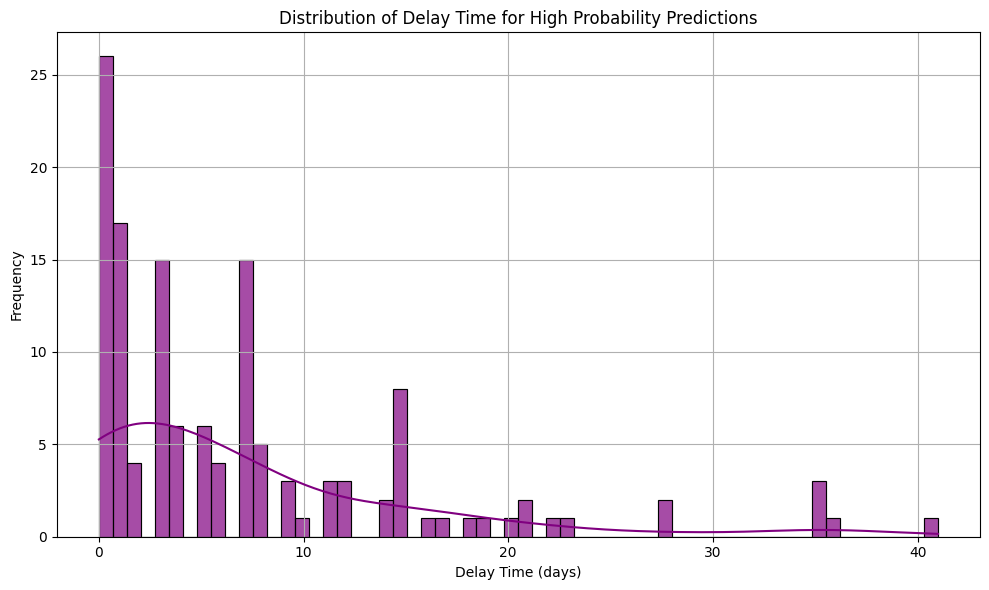

In [32]:
# Filter the dataframe where y_pred is 1
machine_learning_combined = machine_learning
machine_learning_combined.loc[X_test.index, 'y_pred_proba'] = y_pred_proba
machine_learning_combined = machine_learning[machine_learning['y_pred_proba'].notnull()]
# Filter the dataframe where y_pred_proba > 0.5
high_proba_df = machine_learning_combined[machine_learning_combined['y_pred_proba'] > 0.8]

# Plot the distribution of delay_time
plt.figure(figsize=(10, 6))
sns.histplot(high_proba_df['delay_time'], bins=60, kde=True, color='purple', alpha=0.7)
plt.title('Distribution of Delay Time for High Probability Predictions')
plt.xlabel('Delay Time (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Create binary target variable
machine_learning_combined['delay_binary'] = (machine_learning_combined['delay_time'] > 10).astype(int)

# Define features and target
features = ['unique_seller_count', 'delivery_time_buffer', 'product_count', 'estimate_length', 
            'freight_value', 'freight_per_weight', 'price', 'distance', 'avg_neighbor_distance_km', 
            'same_state', 'same_city']
X = machine_learning_combined[features]
y = machine_learning_combined['delay_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9752559726962458

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      4572
           1       0.00      0.00      0.00       116

    accuracy                           0.98      4688
   macro avg       0.49      0.50      0.49      4688
weighted avg       0.95      0.98      0.96      4688



/var/folders/vc/ydqs1m4s6w35gmq4jfdzwvxw0000gn/T/ipykernel_61342/2008906786.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_learning_combined['delay_binary'] = (machine_learning_combined['delay_time'] > 10).astype(int)
/opt/anaconda3/envs/olist/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/anaconda3/envs/olist/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/anaconda3/envs/olist/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in mat